### Init

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np, sys, os
sys.path.insert(1, '../../')
in_colab = 'google.colab' in sys.modules
# fetching code and data(if you are using colab
if in_colab:
    !rm -rf s2search
    !git clone --branch pipelining https://github.com/youyinnn/s2search.git
    sys.path.insert(1, './s2search')
    %cd s2search/pipelining/pdp-exp1/

pic_dir = os.path.join('.', 'plot')
if not os.path.exists(pic_dir):
    os.mkdir(pic_dir)


### SHAP

In [2]:
import shap
shap.initjs()
import json
from getting_data import load_sample
from ranker_helper import init_ranker
from s2search.features import feature_names
from s2search.features import make_features, posthoc_score_adjust
import lightgbm

# df = load_sample('pdp-hs-exp1', 'cslg-rand-500-1')
df = load_sample('pdp-hs-exp1', 'cslg-simple')

ranker = init_ranker('../../s2search_data')

query = str('Machine Learning')

X = np.array([
    make_features(query, ranker.prepare_result(paper), ranker.lms) 
    for paper in json.loads(df.to_json(orient='records'))
])

# ranker.score(query, json.loads(df.to_json(orient='records')))

# ranker.model.predict = None

# def predict_with_post_hoc(x, num_iteration, pred_contrib):
#     scores = old_predict(x, num_iteration, pred_contrib)
#     return posthoc_score_adjust(scores, x, query)

# ranker.model.predict = predict_with_post_hoc
class proxy_model(lightgbm.basic.Booster):
    def __init__(self, ranker):
        self.ranker = ranker
        self.model = ranker.model
        
        # copy all attrs from model
        for key in ranker.model.__dict__.keys():
            # print(key,  ranker.model.__dict__[key])
            setattr(self, key,  ranker.model.__dict__[key])
    
    def predict(self, x, **kws):
        return self.inner_predict(x, **kws)
    
    def inner_predict(self, x, **kws):
        # scores = self.model.predict(x, **kws)
        # print(kws)
        scores = self.model.predict(x, **kws)
        for s in scores:
            print(s)
            print(np.sum(s[:len(s)-1]))
        print(self.model.predict(x))
        # print(type(scores))
        # print(scores)
        return scores
    
    def get_paper_from_array(self, x):
        paper = []
        for d in x:
            paper.append({
                'title': d[0],
                'abstract': d[1],
                'venue': d[2],
                'authors': d[3],
                'year': d[4],
                'n_citations': d[5],
            })
        return paper
    
pm = proxy_model(ranker)
# pd = pm.predict(X)

Loading ranker model...
Load the s2 ranker within 9.58 sec


### Proxy

[ 0.00000000e+00  1.59628410e-03 -8.10352707e-01 -5.34367232e-01
 -5.39728726e-01  3.32873674e-02 -2.63690696e-02 -1.49936763e-02
 -2.67348872e-05 -4.23535098e-05 -4.00697449e-05 -1.22823109e-03
 -2.96592168e-02  3.32809669e-02  1.09754186e+00 -9.56826264e-02
 -3.44647282e-02 -1.54524312e-01 -4.52393389e-02  2.23196804e-01
  4.68886889e-06 -1.05014059e-03 -4.13832326e+00]
-0.8988611909106505
[ 0.00000000e+00  1.41780584e-03 -8.76521730e-01 -5.90475951e-01
 -5.65353955e-01 -2.47546522e-02 -5.03299733e-02 -2.37385366e-02
 -3.78084149e-05 -4.28229083e-05 -5.08556724e-05 -2.16434861e-03
 -3.04414887e-02  3.45796503e-02  5.59496713e-01 -1.19788078e-01
 -4.35000022e-02 -1.49984530e-01 -2.25211280e-01  1.15556544e-01
  1.13669780e-03 -4.02338375e-05 -4.13832326e+00]
-1.9902488350590277
[ 0.00000000e+00  2.26281119e-04  1.67303232e-01 -3.43162711e-02
 -6.01227333e-01  3.26753421e-02 -8.60080119e-04 -1.53296119e-02
 -8.30518361e-05 -1.13352585e-04 -1.60397499e-04 -7.81231611e-04
 -1.87722206e-0

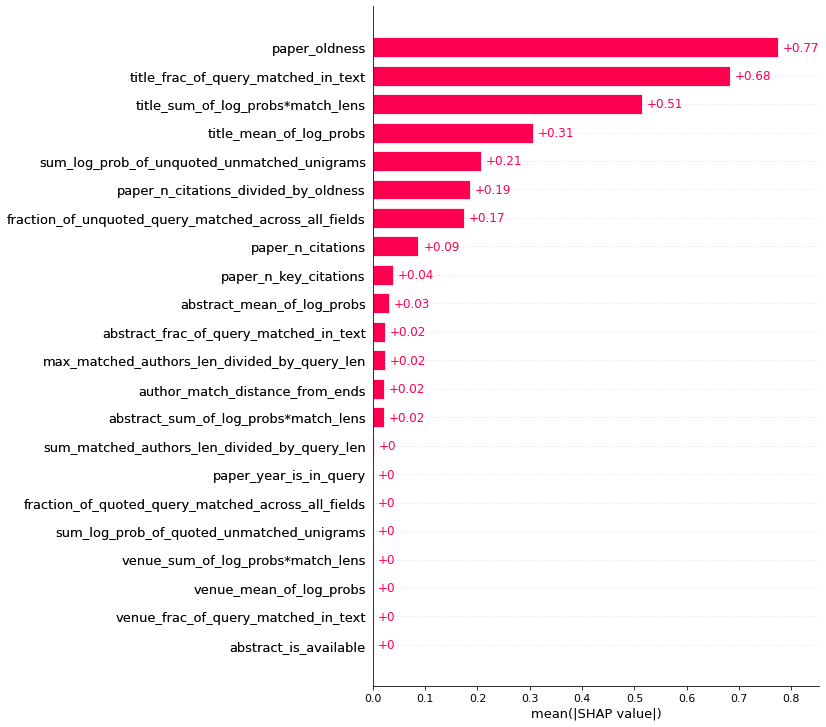

In [3]:
explainer = shap.TreeExplainer(pm, feature_names=feature_names)
shap_values = explainer(X)

import matplotlib.pyplot as plt
fig = plt.figure()

fig.patch.set_facecolor('xkcd:white')

# shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values, max_display=22, show=False)
shap.plots.force(shap_values[0])